In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [33]:
def plot_roc(model, x_columns, y_true):

    y_pred = model.predict_proba(x_columns)

    fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
    area_under_curve = auc(fpr, tpr)

    # method I: plt
    fig, ax = plt.subplots()
    model_name = str(type(model)).split('.')[-1].strip(">\'")
    plt.title(f'{model_name} ROC')
    ax.plot(fpr, tpr, 'k', label = 'C AUC = %0.3f' % area_under_curve)

    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [3]:
df = pd.read_csv('../data/featurized_dataframe.csv')

In [55]:
yelp_columns = ['restaurant_count','review_count','stars',
    'Attribute|has_Alcohol', 'Attribute|has_Ambience|casual', 'Attribute|has_Ambience|classy', 
                'Attribute|has_Ambience|divey', 'Attribute|has_Ambience|hipster', 
                'Attribute|has_Ambience|intimate', 'Attribute|has_Ambience|romantic', 
                'Attribute|has_Ambience|touristy', 'Attribute|has_Ambience|trendy', 
                'Attribute|has_Ambience|upscale', 'Attribute|has_BikeParking', 
                'Attribute|has_BusinessAcceptsCreditCards', 'Attribute|has_BusinessParking|garage', 
                'Attribute|has_BusinessParking|lot', 'Attribute|has_BusinessParking|street', 
                'Attribute|has_BusinessParking|valet', 'Attribute|has_BusinessParking|validated', 
                'Attribute|has_Caters', 'Attribute|has_CoatCheck', 'Attribute|has_DogsAllowed', 
                'Attribute|has_DriveThru', 'Attribute|has_GoodForDancing', 'Attribute|has_GoodForKids', 
                'Attribute|has_GoodForMeal|breakfast', 'Attribute|has_GoodForMeal|brunch', 
                'Attribute|has_GoodForMeal|dessert', 'Attribute|has_GoodForMeal|dinner', 
                'Attribute|has_GoodForMeal|latenight', 'Attribute|has_GoodForMeal|lunch', 
                'Attribute|has_HappyHour', 'Attribute|has_HasTV', 'Attribute|has_Music|background_music', 
                'Attribute|has_Music|dj', 'Attribute|has_Music|jukebox', 'Attribute|has_Music|karaoke', 
                'Attribute|has_Music|live', 'Attribute|has_Music|no_music', 'Attribute|has_Music|video', 
                'Attribute|has_NoiseLevel', 'Attribute|has_OutdoorSeating', 'Attribute|has_RestaurantsAttire', 
                'Attribute|has_RestaurantsDelivery', 'Attribute|has_RestaurantsGoodForGroups', 
                'Attribute|has_RestaurantsPriceRange2', 'Attribute|has_RestaurantsReservations', 
                'Attribute|has_RestaurantsTableService', 'Attribute|has_RestaurantsTakeOut', 
                'Attribute|has_Smoking', 'Attribute|has_WheelchairAccessible', 'Attribute|has_WiFi', 
                'Category|American (New)_true', 'Category|American (Traditional)_true', 
                'Category|Arts & Entertainment_true', 'Category|Asian Fusion_true', 
                'Category|Automotive_true', 'Category|Bakeries_true', 'Category|Barbeque_true', 
                'Category|Bars_true', 'Category|Beer_true', 'Category|Breakfast & Brunch_true', 
                'Category|Burgers_true', 'Category|Cafes_true', 'Category|Caterers_true', 
                'Category|Chicken Wings_true', 'Category|Chinese_true', 'Category|Cocktail Bars_true',
                'Category|Coffee & Tea_true', 'Category|Convenience Stores_true', 'Category|Delis_true', 
                'Category|Desserts_true', 'Category|Diners_true', 'Category|Drugstores_true', 
                'Category|Event Planning & Services_true', 'Category|Fast Food_true', 
                'Category|Food Trucks_true', 'Category|Food_true', 'Category|Gas Stations_true', 
                'Category|Grocery_true', 'Category|Ice Cream & Frozen Yogurt_true', 
                'Category|Italian_true', 'Category|Japanese_true', 'Category|Juice Bars & Smoothies_true', 
                'Category|Lounges_true', 'Category|Mediterranean_true', 'Category|Mexican_true', 
                'Category|Nightlife_true', 'Category|Pizza_true', 'Category|Pubs_true', 
                'Category|Restaurants_true', 'Category|Salad_true', 'Category|Sandwiches_true', 
                'Category|Seafood_true', 'Category|Shopping_true', 'Category|Specialty Food_true', 
                'Category|Sports Bars_true', 'Category|Steakhouses_true', 'Category|Sushi Bars_true', 
                'Category|Tex-Mex_true', 'Category|Wine & Spirits_true', 'Category|Wine Bars_true']

census_columns = ['2016 ACS 5-Year Population Estimate',
                 'American Indian and Alaska Native alone',
                 'Asian alone',
                 'Black or African American alone',
                 'Census 2010 Total Population',
                 'Educational Attainment: Percent high school graduate or higher',
                 'Foreign Born Population',
                 'Hispanic or Latino (of any race)',
                 'Individuals below poverty level',
                 'Median Age',
                 'Median Household Income',
                 'Native Hawaiian and Other Pacific Islander alone',
                 'Some Other Race alone',
                 'Total housing units',
                 'Two or More Races',
                 'Veterans',
                 'White alone',
                 'White alone, Not Hispanic or Latino']

x_columns = df[yelp_columns + census_columns]

y_true = df[['closed_on_google']]

X_train, X_test, y_train, y_test = train_test_split(x_columns, y_true, test_size=0.33, random_state=42)

In [53]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

ab_model = AdaBoostClassifier()
ab_model.fit(X_train, y_train)

kn_model = KNeighborsClassifier()
kn_model.fit(X_train, y_train)

models = [rf_model, gb_model, lr_model, dt_model, ab_model, kn_model]

/Users/ElliottC/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/ElliottC/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ElliottC/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


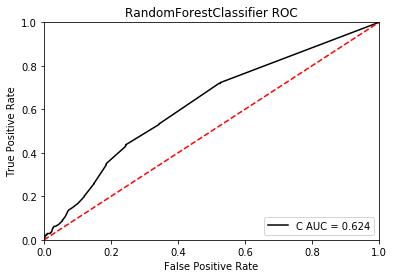

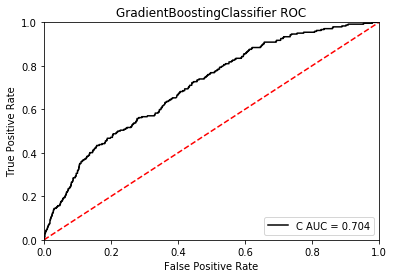

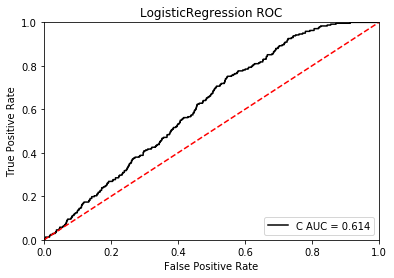

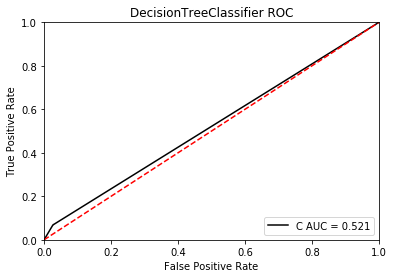

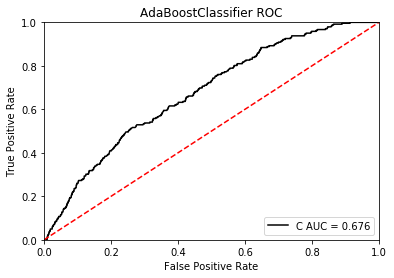

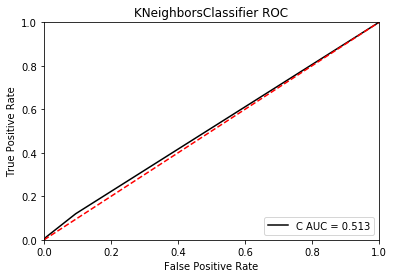

In [54]:
for model in models:
    plot_roc(model, X_test, y_test)

In [307]:
feature_importances = dict(zip(list(x_columns.columns), list(model.coef_[0])))

In [312]:
np.array(feature_importances.values())

array(dict_values([-0.014679197964188557, -0.0027571686037191514, -0.10186302028418913, -0.019640502321069335, -0.017207901471147983, -0.017207901471147983, -0.017046682649769867, -0.017207901471147983, -0.017207901471147983, -0.017207901471147983, -0.017207901471147983, -0.017207901471147983, -0.017207901471147983, -0.03940881619236759, -0.02293727887570852, -0.024796088488173277, -0.024796088488173277, -0.024796088488173277, -0.024796088488173277, -0.024634869666795168, -0.020836284247472026, -0.00631221611141189, 0.0009695343604290249, -0.0023000343619569924, -0.007912050319614984, -0.008111424414662196, -0.011817084946696534, -0.011817084946696534, -0.011817084946696534, -0.011817084946696534, -0.011817084946696534, -0.011817084946696534, -0.007162173516262143, -0.016530889372178007, -0.006247107200103724, -0.006247107200103724, -0.006247107200103724, -0.006247107200103724, -0.006247107200103724, -0.006247107200103724, -0.006247107200103724, -0.011429119015608615, -0.01177116698261

In [278]:
logistic_importances = dict(zip(list(x_columns.columns), list(model.feature_importances_)))

In [279]:
logistic_importances

{'2016 ACS 5-Year Population Estimate': 0.01996612040164029,
 'American Indian and Alaska Native alone': 0.023515067000338154,
 'Asian alone': 0.0178978265230705,
 'Attribute|has_Alcohol': 0.004566759818570165,
 'Attribute|has_Ambience|casual': 0.00225471896580039,
 'Attribute|has_Ambience|classy': 0.0007081506992045379,
 'Attribute|has_Ambience|divey': 0.0022921727808608286,
 'Attribute|has_Ambience|hipster': 0.003584533885762719,
 'Attribute|has_Ambience|intimate': 0.003978920140460055,
 'Attribute|has_Ambience|romantic': 0.0013165206346573565,
 'Attribute|has_Ambience|touristy': 0.001289475989598741,
 'Attribute|has_Ambience|trendy': 0.0013272083741129156,
 'Attribute|has_Ambience|upscale': 0.0017314768506114867,
 'Attribute|has_BikeParking': 0.007205678691389258,
 'Attribute|has_BusinessAcceptsCreditCards': 0.001964083378383265,
 'Attribute|has_BusinessParking|garage': 0.004060973726992212,
 'Attribute|has_BusinessParking|lot': 0.004616839507665905,
 'Attribute|has_BusinessParking|

In [292]:
def get_top_features(model, n_features):
    if type(model)==LogisticRegression:
        feature_importances = dict(zip(list(x_columns.columns), list(model.coef_[0])))
    elif type(model) in [GradientBoostingClassifier, RandomForestClassifier]:
        feature_importances = {}
        for i in range(len(model.feature_importances_)):
            feature_importances[x_columns.columns[i]] = model.feature_importances_[i]
    top_features = Counter(feature_importances).most_common(n_features)
    features = [feature[0] for feature in top_features]
    values = [feature[1] for feature in top_features]
    return features, values

In [ ]:
feature_importances = dict(zip(list(x_columns.columns), list(model.coef_[0])))

In [322]:
top_features, values = get_top_features(model, 100)

In [288]:
features = [feature[0] for feature in top_features]
values = [feature[1] for feature in top_features]

In [224]:
feature_values = {}
for i in range(len(model.coef_)):
    feature_values[x_columns.columns[i]] = model.coef_[i]

In [324]:
features = [feature[0] for feature in top_features]
values = [feature[1] for feature in top_features]

In [325]:
df = pd.DataFrame(list(zip(values,features))).set_index(1).sort_values(0)

df.plot.barh(figsize=(10,10))

TypeError: Empty 'DataFrame': no numeric data to plot